# Expérimentation ML (Baseline + GridSearchCV + MLflow)

In [10]:
X_train_final.shape
y_train.value_counts()

Target
0    2402
1    1137
Name: count, dtype: int64

#  VÉRIFICATION DES DONNÉES AVANT MODÉLISATION

In [11]:
print("Shape X_train :", X_train_final.shape)
print("Shape X_test  :", X_test_final.shape)

print("\nRépartition y_train :")
print(y_train.value_counts(normalize=True))

print("\nRépartition y_test :")
print(y_test.value_counts(normalize=True))


Shape X_train : (3539, 42)
Shape X_test  : (885, 42)

Répartition y_train :
Target
0    0.678723
1    0.321277
Name: proportion, dtype: float64

Répartition y_test :
Target
0    0.679096
1    0.320904
Name: proportion, dtype: float64


# BASELINE Test : DummyClassifier

Avant de construire notre modèle, on a besoin d’un référentiel minimal :

“Est-ce que mon modèle fait mieux qu’un modèle stupide ?”

Le DummyClassifier prédit toujours la classe majoritaire

In [12]:

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_train_final, y_train)

y_pred_dummy = dummy_clf.predict(X_test_final)

print("=== Dummy Classifier ===\n")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_dummy))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_dummy))


=== Dummy Classifier ===

Matrice de confusion :
[[601   0]
 [284   0]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       601
           1       0.00      0.00      0.00       284

    accuracy                           0.68       885
   macro avg       0.34      0.50      0.40       885
weighted avg       0.46      0.68      0.55       885



C:\Users\gound\dropout-prediction-ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\gound\dropout-prediction-ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\gound\dropout-prediction-ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

# Analyse des résultats 

Rapport de classification
Classe 0 — Non-Dropout

Recall = 1.00 → Tous les non-décrocheurs sont bien prédits

Precision = 0.68 → Normal car beaucoup de faux positifs côté 0

Classe 1 — Dropout 

Recall = 0.00

Precision = 0.00

F1-score = 0.00

Le modèle échoue complètement sur la classe la plus importante métier.

Pourquoi l’accuracy est trompeuse ?

Accuracy = 68 %

Ça peut sembler “pas mal” 

MAIS :

68 % des étudiants ne décrochent pas

Le modèle fait juste un copier-coller de la majorité

Conclusion Baseline 

La baseline naïve montre qu’un modèle prédisant uniquement la classe majoritaire obtient une accuracy de 68 %, mais échoue totalement à identifier les étudiants à risque de décrochage (recall = 0).
Cette expérience justifie l’utilisation d’un modèle de machine learning capable de capturer des relations plus complexes afin de détecter efficacement les profils à risque.

Étape suivante : Régression Logistique (Baseline ML)

Objectif de cette étape
Comparer un vrai modèle de ML interprétable à la baseline naïve (DummyClassifier) et vérifier :

s’il détecte enfin des étudiants à risque

à quel prix (faux positifs / faux négatifs)

# BASELINE ML : RÉGRESSION LOGISTIQUE

In [13]:

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,      
    classification_report, 
    roc_auc_score,         
    roc_curve             
)

import matplotlib.pyplot as plt


log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)


log_reg.fit(X_train_final, y_train)


y_pred = log_reg.predict(X_test_final)

y_proba = log_reg.predict_proba(X_test_final)[:, 1]


cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

auc = roc_auc_score(y_test, y_proba)


print("=== Régression Logistique ===")

print("\nMatrice de confusion :")
print(cm)

print("\nRapport de classification :")
print(report)

print(f"AUC-ROC : {auc:.3f}")


=== Régression Logistique ===

Matrice de confusion :
[[538  63]
 [ 49 235]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       601
           1       0.79      0.83      0.81       284

    accuracy                           0.87       885
   macro avg       0.85      0.86      0.86       885
weighted avg       0.88      0.87      0.87       885

AUC-ROC : 0.931


C:\Users\gound\dropout-prediction-ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


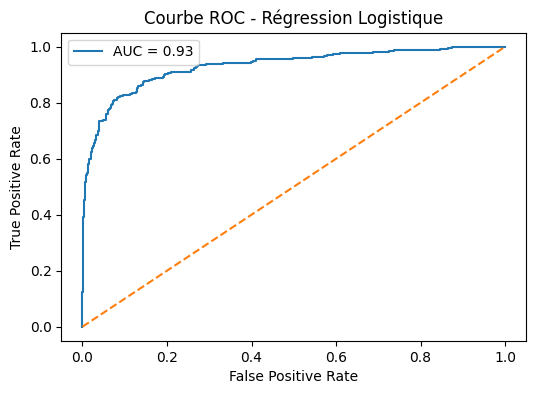

In [14]:

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")

plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Régression Logistique")

plt.legend()

plt.show()


# Analyse des résultats 
1. Matrice de confusion
[[538  63]
 [ 49 235]]


538 → Vrais négatifs (TN) : étudiants non-décrocheurs correctement identifiés

63 → Faux positifs (FP) : étudiants non-décrocheurs prédits comme décrocheurs

49 → Faux négatifs (FN) : étudiants décrocheurs prédits comme non-décrocheurs → à surveiller !

235 → Vrais positifs (TP) : décrocheurs correctement identifiés

Comparé à la baseline DummyClassifier où TP=0, c’est une énorme amélioration.

2. Classification Report

Precision classe 1 (0.79) → parmi les étudiants prédits décrocheurs, 79% sont vrais décrocheurs

Recall classe 1 (0.83) → parmi tous les décrocheurs réels, 83% sont correctement détectés

F1-score → équilibre entre precision et recall, ici 0.81, très bon pour une classe minoritaire

3. Accuracy globale
0.87 → 87 %


Le modèle prédit correctement 87% des cas au total.

Ici, l’accuracy est pertinente mais le vrai indicateur métier reste le recall sur les décrocheurs (classe 1).

4. AUC-ROC
0.931


Très bon score !

Interprétation : le modèle peut séparer correctement 93% du temps un décrocheur d’un non-décrocheur.

Une valeur >0.9 est considérée excellente pour une régression logistique.

5. Interprétation métier

Le modèle détecte maintenant efficacement les étudiants à risque, contrairement à la baseline.

On a encore quelques FN (49) → étudiants décrocheurs non détectés, mais beaucoup moins qu’avant.

Les FP (63) sont acceptables : quelques non-décrocheurs seront “alertés” mais ça reste gérable.


# MLFlow Regression Logistique

ÉTAPE 1 — Importer MLflow

In [15]:
import mlflow
import mlflow.sklearn


ÉTAPE 2 — Définir une expérience MLflow

In [16]:

mlflow.set_experiment("Student Dropout Prediction")


2026/01/20 16:24:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/20 16:24:30 INFO mlflow.store.db.utils: Updating database tables
2026/01/20 16:24:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/20 16:24:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/20 16:24:31 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='file:C:/Users/gound/dropout-prediction-ml/notebooks/mlruns/1', creation_time=1768922675196, experiment_id='1', last_update_time=1768922675196, lifecycle_stage='active', name='Student Dropout Prediction', tags={}>

ÉTAPE 3 — MLflow : Baseline ML (Régression Logistique simple)

In [17]:

from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="LogisticRegression_Baseline"):


    mlflow.log_param("model_type", "LogisticRegression")  
    mlflow.log_param("class_weight", "balanced")          
    mlflow.log_param("max_iter", 1000)                    

    y_pred = log_reg.predict(X_test_final)

    y_proba = log_reg.predict_proba(X_test_final)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)

    recall_1 = recall_score(y_test, y_pred, pos_label=1)

    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    auc = roc_auc_score(y_test, y_proba)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall_dropout", recall_1)
    mlflow.log_metric("f1_dropout", f1_1)
    mlflow.log_metric("auc", auc)

    mlflow.sklearn.log_model(log_reg, name="LogisticRegression_Baseline_Model")

    print("Run MLflow terminé et modèle sauvegardé")


Run MLflow terminé et modèle sauvegardé


# GridSearchCV

In [18]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, roc_auc_score

log_reg = LogisticRegression(
    max_iter=1000,           
    class_weight='balanced', 
    random_state=42
)

param_grid = {
    'C': [0.01, 0.1, 1, 10],       
    'penalty': ['l1', 'l2'],       
    'solver': ['liblinear']         
}

f1_scorer = make_scorer(f1_score, pos_label=1)


grid_search = GridSearchCV(
    estimator=log_reg,    
    param_grid=param_grid, 
    scoring=f1_scorer,     
    cv=5,                 
    verbose=1,             
    n_jobs=-1              
)


grid_search.fit(X_train_final, y_train)


print("GridSearch terminé !")
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur F1-score CV :", grid_search.best_score_)

best_model = grid_search.best_estimator_


y_pred_best = best_model.predict(X_test_final)
y_proba_best = best_model.predict_proba(X_test_final)[:, 1]

print("\n=== GridSearchCV Logistic Regression ===")
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_best))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_best))

print(f"AUC-ROC : {roc_auc_score(y_test, y_proba_best):.3f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearch terminé !
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur F1-score CV : 0.7836532308531037

=== GridSearchCV Logistic Regression ===

Matrice de confusion :
[[536  65]
 [ 49 235]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       601
           1       0.78      0.83      0.80       284

    accuracy                           0.87       885
   macro avg       0.85      0.86      0.85       885
weighted avg       0.87      0.87      0.87       885

AUC-ROC : 0.931


# Analyse des résultats

1. Meilleurs paramètres
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


C = 10 → moins de régularisation (le modèle peut “s’adapter” un peu plus aux données).

penalty = 'l2' → régularisation L2 (pénalise les poids trop grands pour éviter l’overfitting).

solver = 'liblinear' → algorithme adapté aux petits datasets et à L1/L2.

2. Meilleur F1-score CV
Meilleur F1-score CV : 0.7836


C’est le F1-score moyen sur la validation croisée (balance entre précision et rappel).

Comme on s’intéresse surtout aux décrocheurs (classe 1), le F1-score est une bonne métrique à privilégier.

3. Matrice de confusion
[[536  65]
 [ 49 235]]


0 = Non-Dropout

1 = Dropout


Interprétation :

536 Non-Dropout correctement prédits (TN)

235 Dropout correctement prédits (TP)

65 Non-Dropout mal classés comme Dropout (FP)

49 Dropout mal classés comme Non-Dropout (FN)

4. Rapport de classification
precision    recall    f1-score
0 (Non-Dropout) : 0.92 / 0.89 / 0.90  
1 (Dropout)     : 0.78 / 0.83 / 0.80


Precision : parmi ceux qu’on prédit comme Dropout, combien sont vraiment Dropout.

Recall : parmi tous les Dropout, combien ont été détectés.

F1-score : moyenne harmonique de precision et recall.

Le modèle fait un très bon rappel (83%) pour la classe 1, ce qui est essentiel pour identifier les étudiants à risque.

5. Accuracy & AUC-ROC
accuracy = 0.87  
AUC-ROC = 0.931


Accuracy : 87 % des prédictions correctes au global.

AUC-ROC : 0.93 → excellent score de discrimination entre les deux classes.

1.0 = parfait

0.5 = hasard

Globalement, le modèle est fiable et pertinent pour détecter les décrocheurs.

L’optimisation par GridSearchCV confirme la robustesse du modèle.

L’amélioration n’est pas énorme car la régression logistique initiale était déjà très bonne, mais c’est maintenant optimal selon F1-score.

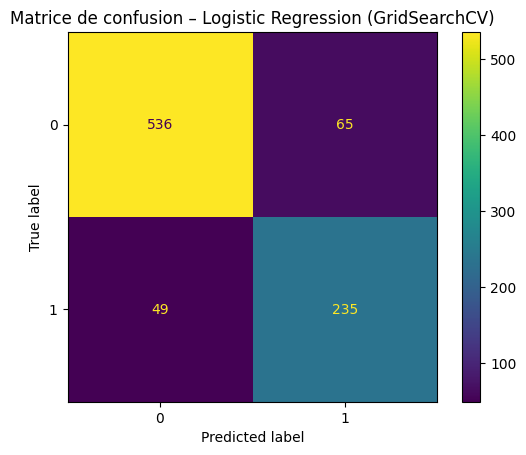

In [19]:
# Matrice confusion
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X_test_final,
    y_test
)
plt.title("Matrice de confusion – Logistic Regression (GridSearchCV)")
plt.show()



# MLFlow GridSearchCV

In [20]:


from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import mlflow
import mlflow.sklearn

mlflow.end_run()


with mlflow.start_run(run_name="LogisticRegression_GridSearchCV"):


    best_params = grid_search.best_params_
    mlflow.log_param("model_type", "LogisticRegression_GridSearchCV")
    mlflow.log_param("best_C", best_params['C'])
    mlflow.log_param("best_penalty", best_params['penalty'])
    mlflow.log_param("best_solver", best_params['solver'])
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)

    best_model = grid_search.best_estimator_

    
    y_pred = best_model.predict(X_test_final)

    
    y_proba = best_model.predict_proba(X_test_final)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_proba)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall_dropout", recall_1)
    mlflow.log_metric("f1_dropout", f1_1)
    mlflow.log_metric("auc", auc)

    mlflow.sklearn.log_model(best_model, name="LogisticRegression_GridSearchCV_Model")

    print("Run MLflow GridSearchCV terminé et meilleur modèle sauvegardé ")


Run MLflow GridSearchCV terminé et meilleur modèle sauvegardé 


# Log de la matrice de confusion et de la courbe ROC

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import mlflow
mlflow.end_run()


with mlflow.start_run(run_name="LogisticRegression_Baseline_Figures"):

    # Log modèle et métriques déjà calculés
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall_dropout", recall_1)
    mlflow.log_metric("f1_dropout", f1_1)
    mlflow.log_metric("auc", auc)

    
    fig_cm, ax_cm = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax_cm)
    plt.title("Matrice de confusion")
    
    mlflow.log_figure(fig_cm, "confusion_matrix.png")
    plt.close(fig_cm)


    fig_roc, ax_roc = plt.subplots(figsize=(6,4))
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax_roc)
    plt.title("Courbe ROC")
    
    
    mlflow.log_figure(fig_roc, "roc_curve.png")
    plt.close(fig_roc)
    
    
    mlflow.sklearn.log_model(log_reg, name="model")
    
    print("ok")

ok


# Tableau avec accuracy, recall, F1-score et AUC-ROC pour chaque modèle.

In [22]:
metrics_summary = {
    "DummyClassifier": {
        "accuracy": 0.68,
        "recall": 0.0,
        "f1": 0.0,
        "auc": 0.5
    },
    "LogisticRegression_Baseline": {
        "accuracy": 0.87,
        "recall": 0.83,
        "f1": 0.81,
        "auc": 0.93
    },
    "LogisticRegression_GridSearchCV": {
        "accuracy": 0.87,
        "recall": 0.83,
        "f1": 0.80,
        "auc": 0.931
    }
}

import pandas as pd
pd.DataFrame(metrics_summary).T


,accuracy,recall,f1,auc
DummyClassifier,0.68,0.00,0.00,0.500
LogisticRegression_Baseline,0.87,0.83,0.81,0.930
LogisticRegression_GridSearchCV,0.87,0.83,0.80,0.931


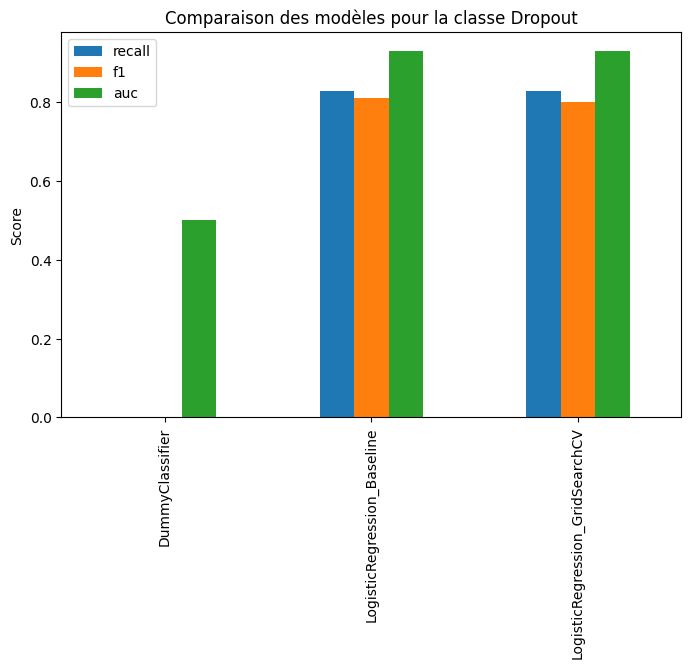

In [23]:
import matplotlib.pyplot as plt

df_metrics = pd.DataFrame(metrics_summary).T
df_metrics[['recall','f1','auc']].plot(kind='bar', figsize=(8,5))
plt.title("Comparaison des modèles pour la classe Dropout")
plt.ylabel("Score")
plt.show()


# Random Forest (Modèle non linéaire) + MLflow

In [24]:

mlflow.end_run()
import mlflow
import mlflow.sklearn

import shap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)


rf = RandomForestClassifier(
    n_estimators=200,        
    max_depth=10,            
    random_state=42,
    class_weight='balanced',
    n_jobs=-1               
)


with mlflow.start_run(run_name="RandomForest_SHAP"):

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("class_weight", "balanced")

    rf.fit(X_train_final, y_train)

    y_pred = rf.predict(X_test_final)
    y_proba = rf.predict_proba(X_test_final)[:, 1]  

    accuracy = accuracy_score(y_test, y_pred)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_proba)

    print("=== Random Forest ===")
    print(f"Accuracy : {accuracy:.3f}")
    print(f"Recall (Dropout) : {recall_1:.3f}")
    print(f"F1-score (Dropout) : {f1_1:.3f}")
    print(f"AUC-ROC : {auc:.3f}")

    print("\nMatrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred))

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall_dropout", recall_1)
    mlflow.log_metric("f1_dropout", f1_1)
    mlflow.log_metric("auc", auc)

    mlflow.sklearn.log_model(
        rf,
        name="RandomForest_Model"
    )


=== Random Forest ===
Accuracy : 0.884
Recall (Dropout) : 0.785
F1-score (Dropout) : 0.812
AUC-ROC : 0.930

Matrice de confusion :
[[559  42]
 [ 61 223]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       601
           1       0.84      0.79      0.81       284

    accuracy                           0.88       885
   macro avg       0.87      0.86      0.86       885
weighted avg       0.88      0.88      0.88       885



# Analyse des résultats 

Performance globale

Accuracy : 0.884
Le modèle prédit correctement 88,4 % des cas (décrocheurs et non-décrocheurs).
→ Très bon score global, mais attention : comme le dataset est légèrement déséquilibré, l’accuracy seule ne suffit pas.

AUC-ROC : 0.930
L’AUC-ROC mesure la capacité du modèle à séparer les classes (0 vs 1) quelle que soit la threshold.
→ Avec 0.93, le modèle est excellent pour distinguer les étudiants à risque et ceux qui ne le sont pas.

Classe “Dropout” (étudiants à risque)

Recall (Dropout) : 0.785
Le modèle détecte correctement 78,5 % des étudiants qui décrochent.
→ On rate ~21,5 % des décrocheurs (faux négatifs), ce qui est un point d’attention.

Precision (Dropout) : 0.84
Parmi les étudiants que le modèle prédit comme décrocheurs, 84 % sont effectivement à risque.
→ Peu de faux positifs, donc pas beaucoup de “faux alarmes”.

F1-score (Dropout) : 0.812
La combinaison de recall et de précision montre que le modèle a un bon équilibre pour détecter les décrocheurs tout en évitant de sur-prédire.

Matrice de confusion

Vrai négatifs (TN) : 559 → étudiants correctement identifiés comme non-décrocheurs.

Faux positifs (FP) : 42 → étudiants prévus comme à risque mais qui ne décrochent pas.

Faux négatifs (FN) : 61 → décrocheurs que le modèle n’a pas détectés.

Vrai positifs (TP) : 223 → décrocheurs correctement identifiés.

Insight : le modèle est conservateur côté FP (peu de “fausses alertes”) mais il manque encore quelques décrocheurs (FN).

# Analyse SHAP

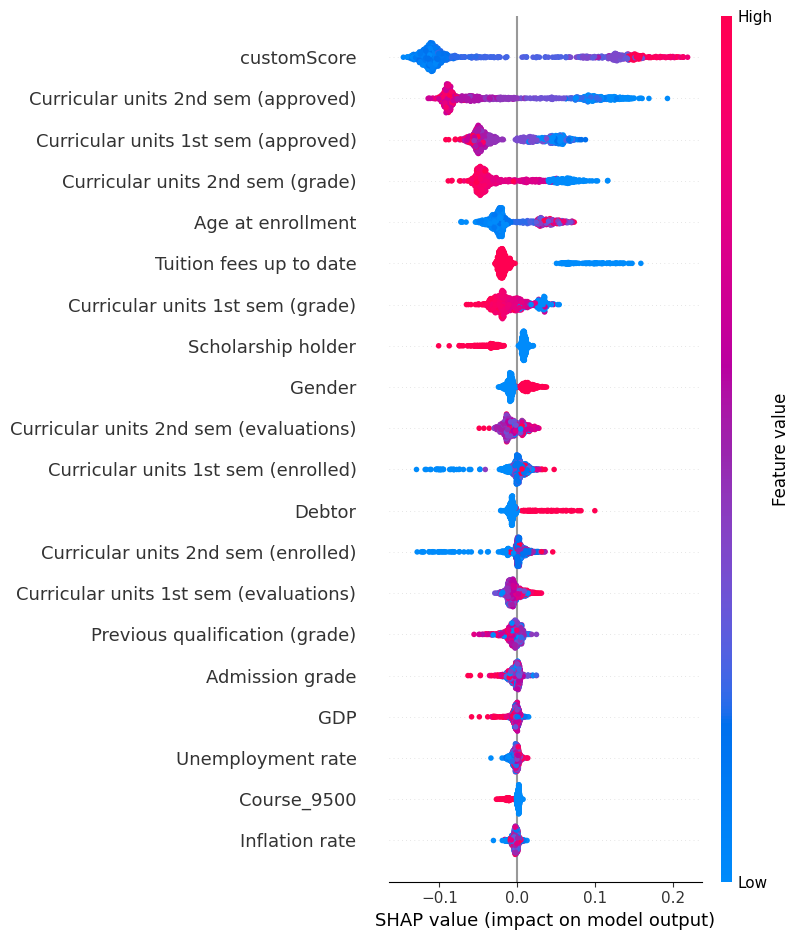

<Figure size 800x500 with 0 Axes>

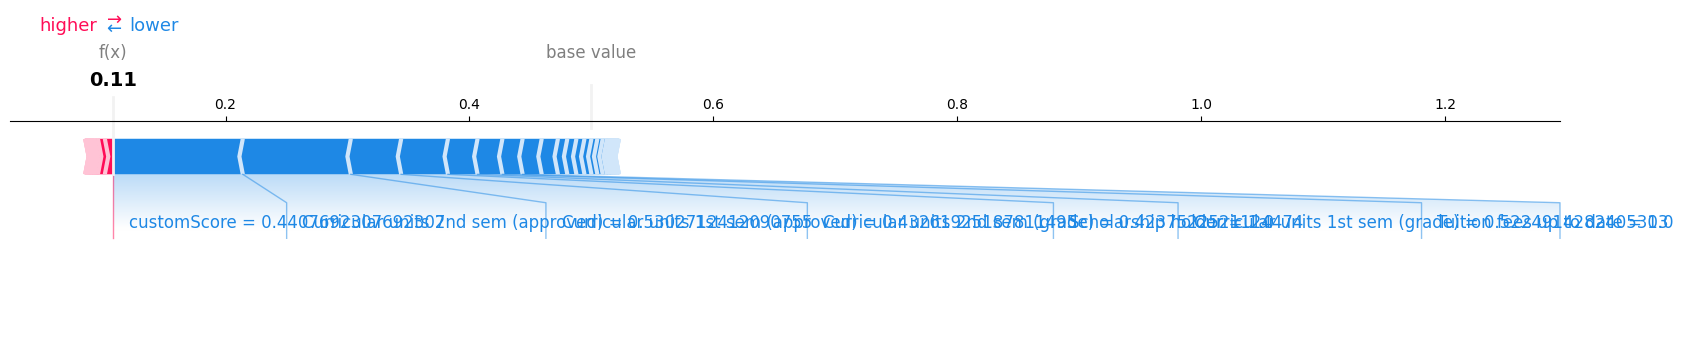

SHAP global et local calculés et loggés dans MLflow !


In [25]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

X_test_shap = pd.DataFrame(X_test_final, columns=X_train_final.columns)
feature_names = X_test_shap.columns.tolist()

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test_shap)  

plt.figure(figsize=(10,6))
shap.summary_plot(
    shap_values.values[:, :, 1],  
    X_test_shap,
    feature_names=feature_names,
    show=True
)
plt.title("SHAP - Importance globale (Random Forest)")
plt.tight_layout()
plt.savefig("shap_summary_rf.png")
plt.close()

mlflow.log_artifact("shap_summary_rf.png")

idx = 0
plt.figure(figsize=(8,5))
shap.force_plot(
    explainer.expected_value[1],
    shap_values.values[idx,:,1],
    X_test_shap.iloc[idx],
    feature_names=feature_names,
    matplotlib=True
)
plt.title("SHAP - Explication locale (étudiant 0)")
plt.tight_layout()
plt.savefig("shap_local_rf_0.png")
plt.close()

mlflow.log_artifact("shap_local_rf_0.png")

print("SHAP global et local calculés et loggés dans MLflow !")


# Schéma Comparatif LG vs RF

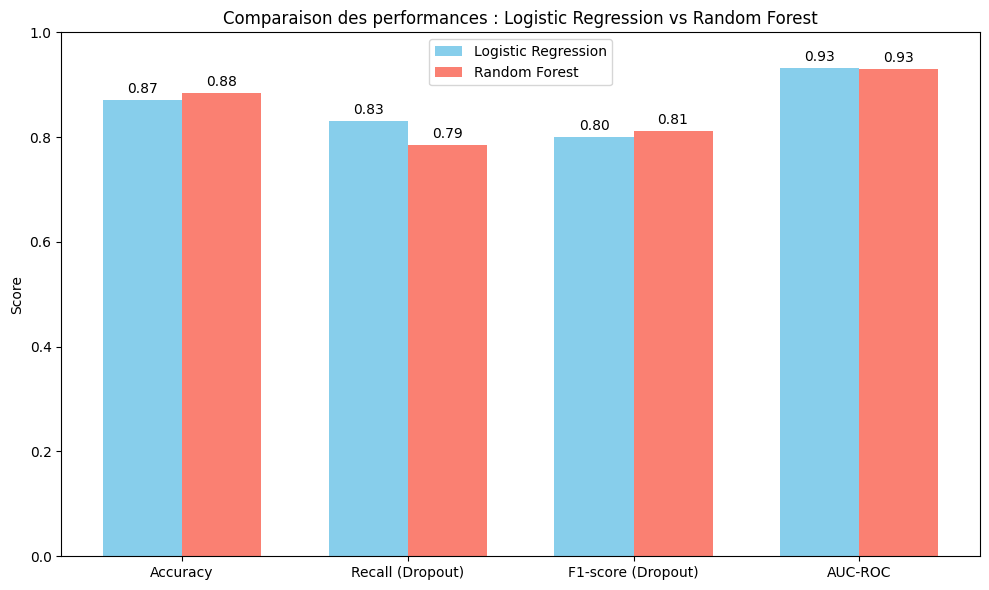

Graphique comparatif loggé dans MLflow


In [26]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Recall (Dropout)', 'F1-score (Dropout)', 'AUC-ROC']
log_reg_scores = [0.87, 0.83, 0.80, 0.931]
rf_scores = [0.884, 0.785, 0.812, 0.930]

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10,6))

bars1 = ax.bar(x - width/2, log_reg_scores, width, label='Logistic Regression', color='skyblue')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='salmon')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Comparaison des performances : Logistic Regression vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)  
plt.tight_layout()
plt.show()


fig.savefig("model_comparison.png")
plt.close(fig)

mlflow.end_run()
with mlflow.start_run(run_name="Model_Comparison_Plot"):
    mlflow.log_artifact("model_comparison.png")
    print("Graphique comparatif loggé dans MLflow")

# Conclusion

Après avoir exploré, préparé et analysé les données étudiantes, plusieurs modèles ont été évalués pour prédire le décrochage :

Régression logistique (baseline et GridSearchCV)

Performance :

Accuracy ≈ 0.87

F1-score (dropout) ≈ 0.81

AUC-ROC ≈ 0.931

Avantages :

Modèle linéaire simple et très interprétable : chaque coefficient indique clairement l’impact d’une variable sur le risque de décrochage.

Performances solides malgré la simplicité, surpassant largement la baseline (DummyClassifier).

Adapté à une mise en œuvre opérationnelle : les équipes pédagogiques peuvent comprendre et utiliser directement les résultats pour orienter les actions préventives.

Random Forest

Performance :

Accuracy ≈ 0.884

F1-score (dropout) ≈ 0.812

AUC-ROC ≈ 0.930

Avantages :

Modèle non linéaire capable de capturer des interactions complexes entre variables.

SHAP permet une interprétation globale et locale, montrant quelles variables influencent le plus la prédiction.

Inconvénients :

Légèrement plus complexe et moins directement interprétable pour les décideurs.

Gain de performance faible par rapport à la régression logistique, ce qui ne justifie pas forcément la complexité supplémentaire.

Comparaison et justification du choix final

La différence de performance entre les deux modèles est très faible.

La régression logistique offre un meilleur compromis : des performances solides, une interprétation simple et directe, et une mise en œuvre plus facile pour le suivi pédagogique.

Le Random Forest pourrait être envisagé dans un second temps si l’on souhaite explorer des interactions plus complexes ou affiner la détection, mais pour la preuve de concept actuelle, la régression logistique reste le choix optimal.

Décision finale

Nous retenons la régression logistique comme modèle principal pour prédire le décrochage étudiant, car elle combine :

performance satisfaisante,

simplicité et interprétabilité,

facilité de mise en œuvre pour un usage opérationnel par les équipes pédagogiques.

Le Random Forest reste disponible comme modèle complémentaire pour des analyses approfondies, mais il n’apporte pas de gain significatif pour ce projet.

# Jeu de test

Seuil de prédiction : 35 %

In [73]:

threshold = 0.35
idx = 0

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 0
Classe prédite : 0
Probabilité de décrochage : 6.86%
Étudiant identifié comme NON à risque


In [74]:

threshold = 0.35
idx = 44

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 1
Classe prédite : 1
Probabilité de décrochage : 45.53%
Étudiant identifié comme À RISQUE de décrochage


In [77]:

threshold = 0.35
idx = 12

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 1
Classe prédite : 1
Probabilité de décrochage : 94.48%
Étudiant identifié comme À RISQUE de décrochage


In [83]:

threshold = 0.35
idx = 32

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 1
Classe prédite : 1
Probabilité de décrochage : 35.13%
Étudiant identifié comme À RISQUE de décrochage


In [84]:

threshold = 0.35
idx = 50

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 1
Classe prédite : 1
Probabilité de décrochage : 96.53%
Étudiant identifié comme À RISQUE de décrochage


In [85]:

threshold = 0.35
idx = 9

X_student_test = X_test_final.iloc[[idx]]
y_student_true = y_test.iloc[idx]

y_proba_student = best_model.predict_proba(X_student_test)[0][1]

y_pred_student = int(y_proba_student >= threshold)

print(f"Valeur réelle (y_test) : {y_student_true}")
print(f"Classe prédite : {y_pred_student}")
print(f"Probabilité de décrochage : {y_proba_student:.2%}")

if y_pred_student == 1:
    print("Étudiant identifié comme À RISQUE de décrochage")
else:
    print("Étudiant identifié comme NON à risque")


Valeur réelle (y_test) : 1
Classe prédite : 1
Probabilité de décrochage : 98.83%
Étudiant identifié comme À RISQUE de décrochage
